<a href="https://colab.research.google.com/github/AdityaRaj26/Image-Colorization/blob/main/Image_coloring_using_conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import os
torch.manual_seed(0)
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage
import cv2
from skimage import io, color

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 2, use_dropout = False, use_bn = False):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size= 4, stride = stride, padding = 1, padding_mode = "reflect")
        self.activation = nn.LeakyReLU(0.2)

        if use_bn == True:
            self.bn = nn.BatchNorm2d(out_channels)
        self.use_bn = use_bn
        if use_dropout == True:
            self.drop = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):

        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.activation(x)
        if self.use_dropout:
            x = self.drop(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, hidden_channels = 64):
        super(Discriminator, self).__init__()

        self.initial = ConvBlock(in_channels, hidden_channels)

        self.block1 = ConvBlock(hidden_channels, hidden_channels*2, use_bn= True) #64 -> 128
        self.block2 = ConvBlock(hidden_channels*2, hidden_channels*4, use_bn= True) #128 -> 256
        self.block3 = ConvBlock(hidden_channels*4, hidden_channels*8, use_bn= True) #256 -> 512
        self.block4 = ConvBlock(hidden_channels*8, hidden_channels*8, use_bn= True, stride = 1) #512
        #self.block5 = ConvBlock(hidden_channels*8, hidden_channels*8, use_bn= True, stride = 1) 
        #512
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1, padding= 1, padding_mode="reflect")
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.initial(x)
        x1 = self.block1(x0)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        #x5 = self.block5(x4)
        x6 = self.final(x4)
        xn = self.sigmoid(x6)
        return xn

In [ ]:
def test():
    x = torch.randn((2,3,256,256))
    y = torch.randn((2,3,256,256))

    model = Discriminator(6)
    pred = model(x,y)
    print(pred.shape)

test()

torch.Size([2, 1, 17, 17])


In [ ]:
import urllib.request
url = 'http://images.cocodataset.org/zips/test2017.zip'
filename = 'coco.zip'
urllib.request.urlretrieve(url, filename)

('coco.zip', <http.client.HTTPMessage at 0x7f59ba9c1450>)

In [ ]:
import zipfile
import os
with zipfile.ZipFile("coco.zip","r") as zip_ref:
        zip_ref.extractall("./images")

In [ ]:
len(os.listdir('./images/test2017'))

40670

In [ ]:
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False, use_bn=False, stride = 2):
        super(DecodeBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=stride, padding = 1)

        self.activation = nn.ReLU()

        if use_bn == True:
            self.bn = nn.BatchNorm2d(out_channels)
        self.use_bn = use_bn

        if use_dropout == True:
            self.drop = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.up(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.activation(x)
        if self.use_dropout:
            x = self.drop(x)
        return x


In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels, hidden_channels = 64, out_channels = 2):
        super(Generator, self).__init__()

        self.initial = ConvBlock(in_channels, hidden_channels)
        self.contract1 = ConvBlock(hidden_channels, hidden_channels*2, use_bn=True, use_dropout=False)
        self.contract2 = ConvBlock(hidden_channels*2, hidden_channels*4, use_bn=True, use_dropout=False)
        self.contract3 = ConvBlock(hidden_channels*4, hidden_channels*8, use_bn=True, use_dropout=False)
        self.contract4 = ConvBlock(hidden_channels*8, hidden_channels*8, use_bn=True, use_dropout=False)
        self.contract5 = ConvBlock(hidden_channels*8, hidden_channels*8, use_bn=True, use_dropout=False)
        self.contract6= ConvBlock(hidden_channels*8, hidden_channels*8, use_bn=True, use_dropout=False)
        self.contract7 = ConvBlock(hidden_channels*8, hidden_channels*8, use_bn=False, use_dropout=False)

        hidden_channels = hidden_channels*8
        self.expand1 = DecodeBlock(hidden_channels, hidden_channels, use_dropout=True, use_bn=True)
        self.expand2 = DecodeBlock(hidden_channels*2, hidden_channels, use_dropout=True, use_bn=True)
        self.expand3 = DecodeBlock(hidden_channels*2, hidden_channels, use_dropout=True, use_bn=True)
        self.expand4 = DecodeBlock(hidden_channels*2, hidden_channels, use_dropout=False, use_bn=True)
        self.expand5 = DecodeBlock(hidden_channels*2, hidden_channels//2, use_dropout=False, use_bn=True)
        self.expand6 = DecodeBlock(hidden_channels, hidden_channels//4, use_dropout=False, use_bn=True)
        self.expand7 = DecodeBlock(hidden_channels//2, hidden_channels//8, use_dropout=False, use_bn=True)
        #self.final_up = DecodeBlock(hidden_channels//4, hidden_channels//8, use_dropout=False, use_bn=False, stride  = 2)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels//4, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    

    def forward(self, x):
        x0 = self.initial(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.contract7(x6)
        x8 = self.expand1(x7)
        x9 = self.expand2(torch.cat([x8, x6], axis= 1))
        x10 = self.expand3(torch.cat([x9, x5], axis= 1))
        x11 = self.expand4(torch.cat([x10, x4], axis= 1))
        x12 = self.expand5(torch.cat([x11, x3], axis= 1))
        x13 = self.expand6(torch.cat([x12, x2], axis= 1))
        x14 = self.expand7(torch.cat([x13, x1], axis= 1))
        #x15 = self.final_up(torch.cat([x14, x0], axis= 1))
        return self.final(torch.cat([x14, x0], axis= 1))
    

In [ ]:
def test_gen():
    x = torch.randn((2,1,256,256))

    model = Generator(1, out_channels=2)
    pred = model(x)
    print(pred.shape)

test_gen()

torch.Size([2, 2, 256, 256])


In [ ]:
transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    #transforms.ToTensor(),
])

In [ ]:
class ColorDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.transform = transform


    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = self.list_files[idx]
        img_path = os.path.join(self.root_dir, img_file)

        sample = Image.open(img_path).convert('RGB')
        if self.transform:
            sample = self.transform(sample)

        sample = np.asarray(sample).reshape(256,256,3)

        lab = (color.rgb2lab(sample) +128)/255
        lab = lab[:,:,1:3].transpose((2,0,1))

        gray = color.rgb2gray(sample)

        sample = torch.from_numpy(lab)
        gray = torch.from_numpy(gray).unsqueeze(0)

        return sample.float(), gray.float()

In [ ]:
dataset = ColorDataset("./images/test2017", transform=transform)

In [ ]:
for _ in range(5):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    #train_features = nn.functional.interpolate(next(iter(dataloader)), size=256)
    img, gray = next(iter(dataloader))
    print(f"AB size: {img.size()}")
    print(f"Gray size: {gray.size()}")

AB size: torch.Size([1, 2, 256, 256])
Gray size: torch.Size([1, 1, 256, 256])
AB size: torch.Size([1, 2, 256, 256])
Gray size: torch.Size([1, 1, 256, 256])
AB size: torch.Size([1, 2, 256, 256])
Gray size: torch.Size([1, 1, 256, 256])
AB size: torch.Size([1, 2, 256, 256])
Gray size: torch.Size([1, 1, 256, 256])
AB size: torch.Size([1, 2, 256, 256])
Gray size: torch.Size([1, 1, 256, 256])


In [ ]:
class UnNormalize(object):
    def __init__(self,mean,std):
        self.mean = mean
        self.std = std
        self.to_tensor = transforms.ToTensor()

    def __call__(self, tensor):
        for t,m,s in zip(self.to_tensor(tensor), self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor.numpy().reshape(256,256,3)

In [ ]:
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 50
input_dim = 1
output_dim = 2
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256
device = 'cuda'

In [ ]:
gen = Generator(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + output_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

(256, 256, 3)


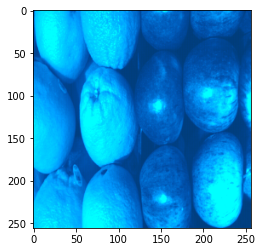

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
img, gray = next(iter(dataloader))
#print(img.shape)
#print(gray.shape)
fake = gen(gray.to(device))
x = torch.cat((gray[0],fake.detach().cpu()[0]),0).numpy().transpose((1,2,0))
x[:,:,0:1] = x[:, :, 0:1] * 100
x[:, :, 1:3] = x[:, :, 1:3] * 255 - 128 
 
x = color.lab2rgb(x.astype(np.float64))
print(x.shape)
plt.imshow(x)
plt.show()

In [ ]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):

    fake = gen(condition)
    fake_disc = disc(fake, condition)
    gen_adv_loss = adv_criterion(fake_disc, torch.ones_like(fake_disc))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss

    return gen_loss

  0%|          | 0/10168 [00:00<?, ?it/s]

Pretrained initial state


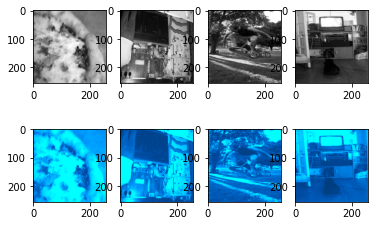

Epoch 0: Step 1000: Generator (U-Net) loss: 132.72352787971482, Discriminator loss: 2.9770360651612284


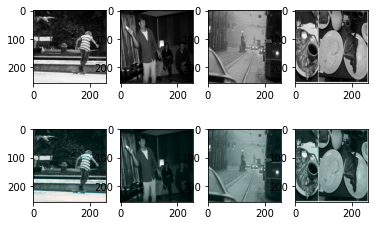

Epoch 0: Step 2000: Generator (U-Net) loss: 49.16728509187696, Discriminator loss: 2.582645813822748


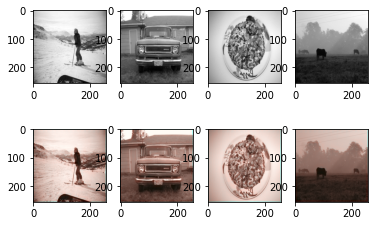

Epoch 0: Step 3000: Generator (U-Net) loss: 45.52085845708846, Discriminator loss: 2.555970530807972


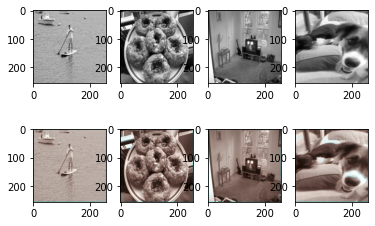

Epoch 0: Step 4000: Generator (U-Net) loss: 44.34773130178455, Discriminator loss: 2.5431218945980083


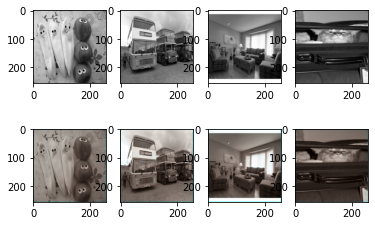

Epoch 0: Step 5000: Generator (U-Net) loss: 42.7653435659408, Discriminator loss: 2.538675075471402


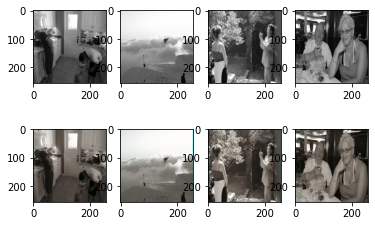

Epoch 0: Step 6000: Generator (U-Net) loss: 42.709961166381824, Discriminator loss: 2.532813093662262


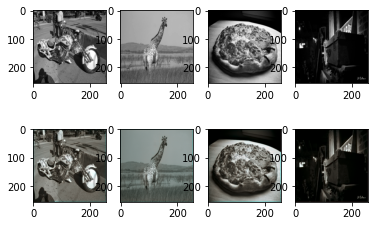

Epoch 0: Step 7000: Generator (U-Net) loss: 42.271305432319615, Discriminator loss: 2.53492479950189


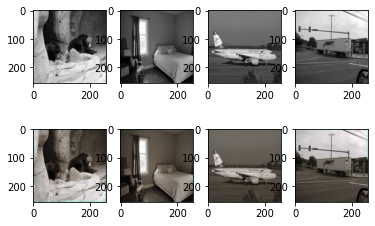

Epoch 0: Step 8000: Generator (U-Net) loss: 42.26677882790568, Discriminator loss: 2.5306455442309357


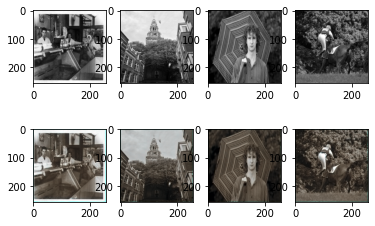

Epoch 0: Step 9000: Generator (U-Net) loss: 42.017977001667006, Discriminator loss: 2.5354064729809753


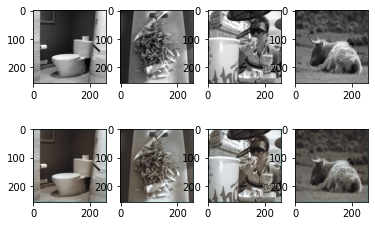

Epoch 0: Step 10000: Generator (U-Net) loss: 41.8337684929371, Discriminator loss: 2.5293618723750115


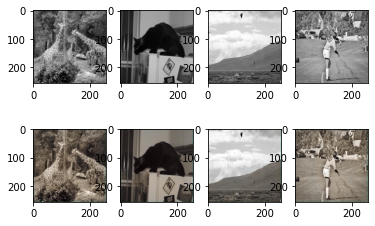

  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/10168 [00:00<?, ?it/s]

In [ ]:
from skimage import color
import numpy as np

def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for ab, gray in tqdm(dataloader):
            cur_batch_size = len(gray)
            condition = gray.to(device)
            real = ab.to(device)

            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if (cur_step % (5*display_step) == 0) and (epoch==0 or (epoch%10)==0):
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                
                f, axrr = plt.subplots(2, batch_size)
                for i in range(2):
                    for j in range(batch_size):
                        x = torch.cat((gray[j],fake.detach().cpu()[j]),0).numpy().transpose((1,2,0))
                        x[:,:,0:1] = x[:, :, 0:1] * 100
                        x[:, :, 1:3] = x[:, :, 1:3] * 255 - 128

                        if i == 0:
                            axrr[i,j].imshow(gray.squeeze().numpy()[j], cmap = "gray")
                        else:
                            axrr[i,j].imshow(color.lab2rgb(x.astype(np.float64)))
                plt.show()
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")
            cur_step += 1
train()